## 1. Imports


In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import deeplake
from lib.dataset import peek_labels

print(tf.__version__)


2.15.0


d:\Programming\Projects\Public\plant-lens\ai\scripts\maker\.venv\Lib\site-packages\deeplake\util\check_latest_version.py:32: UserWarning: A newer version of deeplake (3.8.17) is available. It's recommended that you update to the latest version using `pip install -U deeplake`.
  warnings.warn(


## 2. Load Dataset


In [2]:
ROOT_PATH = "D:/Programming/Projects/Public/plant-lens/ai"
DATASET_DATA_PATH = f"{ROOT_PATH}/data/dataset"

raw_training_dataset = deeplake.load(f'{DATASET_DATA_PATH}/training')
raw_validation_dataset = deeplake.load(f'{DATASET_DATA_PATH}/validation')
raw_testing_dataset = deeplake.load(f'{DATASET_DATA_PATH}/testing')

raw_training_dataset.summary()
raw_validation_dataset.summary()
raw_testing_dataset.summary()

D:/Programming/Projects/Public/plant-lens/ai/data/dataset/training loaded successfully.

D:/Programming/Projects/Public/plant-lens/ai/data/dataset/validation loaded successfully.

D:/Programming/Projects/Public/plant-lens/ai/data/dataset/testing loaded successfully.

Dataset(path='D:/Programming/Projects/Public/plant-lens/ai/data/dataset/training', tensors=['images', 'labels'])

 tensor      htype            shape           dtype  compression
 -------    -------          -------         -------  ------- 
 images      image     (11218, 224, 224, 3)   uint8    jpeg   
 labels   class_label       (11218, 1)       uint16    None   
Dataset(path='D:/Programming/Projects/Public/plant-lens/ai/data/dataset/validation', tensors=['images', 'labels'])

 tensor      htype            shape          dtype  compression
 -------    -------          -------        -------  ------- 
 images      image     (1608, 224, 224, 3)   uint8    jpeg   
 labels   class_label       (1608, 1)       uint16    None  

In [3]:
DIMENSIONS = 224
BATCH_SIZE = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE
STEPS_PER_EPOCH = 10
EPOCHS = 5

data_classes = list(set(sum(raw_training_dataset.labels.data()['text'], [])))
data_classes_count = len(data_classes)


print("Total Number of Classes", data_classes_count)

Total Number of Classes 28


### 2.2 Create Data Pipeline


In [4]:
raw_training_dataset = raw_training_dataset.tensorflow()
raw_validation_dataset = raw_validation_dataset.tensorflow()
raw_testing_dataset = raw_testing_dataset.tensorflow()

In [18]:
import random

""" def data_generator(steps_per_epoch):
    # steps = 0
    # while steps_per_epoch * BATCH_SIZE > steps:
    for data in raw_training_dataset:
        label = data['labels']
        image = data['images']

        yield data
        # steps += 1 """

def data_generator(steps_per_epoch, dataset):
    raw_dataset = None
    match dataset.decode():
        case "training":
            raw_dataset = raw_training_dataset
        case "validation":
            raw_dataset = raw_validation_dataset
        case "testing":
            raw_dataset = raw_testing_dataset

    # labels = [data['labels'].numpy().item() for data in raw_dataset]
    # print({"labels": labels})
    # unique_labels, _, counts = tf.unique_with_counts(labels)
    # print({"unique_labels": unique_labels})

    # label_probabilities = tf.divide(tf.cast(counts, tf.float32), tf.cast(tf.size(labels), tf.float32))
    # print({"label_probabilities": label_probabilities})

    data_by_label = {}
    """     for index, label in enumerate(labels):
        if label not in data_by_label:
            data_by_label[label] = []
        data_by_label[label].append(index) """
  
    for data in raw_dataset:
        label = data['labels'].numpy().item()
        if label not in data_by_label:
            data_by_label[label] = []
        data_by_label[label].append(data)
    
    # for label in data_by_label:
    #     print(label, len(data_by_label[label]))
    
    steps = 0
    while(steps_per_epoch * BATCH_SIZE > steps):
        sampled_label = random.randint(0, len(data_classes_count)-1)

        # for data in data_by_label.get(sampled_label, []):
        yield random.choice(data_by_label.get(sampled_label, []))
        
        steps += 1
        # if steps_per_epoch * BATCH_SIZE <= steps:
        #     break

for value in data_generator(5,"training".encode()):  
    print(value["images"].shape, value["labels"].shape)

def generate_dataset(dataset):
  return tf.data.Dataset.from_generator(data_generator, args=(STEPS_PER_EPOCH,dataset,), output_signature={
      'images': tf.TensorSpec(shape=(DIMENSIONS, DIMENSIONS, 3), dtype=tf.float32),
      'labels': tf.TensorSpec(shape=(1,), dtype=tf.int32),
  })

In [6]:
def augment(image):
    if tf.random.uniform((), minval=0, maxval=1) < 0.5:
        image = tf.image.random_brightness(image, max_delta=0.1)
        image = tf.image.random_contrast(image, lower=0.4, upper=0.8)
    if tf.random.uniform((), minval=0, maxval=1) < 0.5:
        image = tf.tile(tf.image.rgb_to_grayscale(image), [1, 1, 3])
    if tf.random.uniform((), minval=0, maxval=1) < 0.5:
        image = tf.image.random_flip_left_right(image)
    if tf.random.uniform((), minval=0, maxval=1) < 0.5:
        image = tf.image.random_flip_up_down(image)

    return image


# Define a preprocessing function
def preprocess_image(augmentation=False):
    def wrapper(args) -> tuple:
        label = args['labels']
        label = tf.cast(label, tf.int32)
        label = tf.squeeze(label)

        image = augment(args['images']) if augmentation else args['images']
        image = tf.cast(image, tf.float32)
        image = tf.math.divide(image, 255.0)

        return image, label
    return wrapper


training_dataset = generate_dataset('training').map(preprocess_image(augmentation=True), num_parallel_calls=AUTOTUNE)
validation_dataset = generate_dataset('validation').map(preprocess_image(), num_parallel_calls=AUTOTUNE)
testing_dataset = generate_dataset('testing').map(preprocess_image(), num_parallel_calls=AUTOTUNE)

# Shuffle and batch the datasets
training_dataset = training_dataset.shuffle(buffer_size=10000).batch(BATCH_SIZE).prefetch(AUTOTUNE)
validation_dataset = validation_dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)
testing_dataset = testing_dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

In [7]:
for images, labels in training_dataset.take(1):
    print("Training Batch images shape:", images.shape)
    print("Training Batch labels shape:", labels.shape)

for images, labels in validation_dataset.take(1):
    print("Validation Batch images shape:", images.shape)
    print("Validation Batch labels shape:", labels.shape)

for images, labels in testing_dataset.take(1):
    print("Testing Batch images shape:", images.shape)
    print("Testing Batch labels shape:", labels.shape)

Training Batch images shape: (32, 224, 224, 3)
Training Batch labels shape: (32,)
Validation Batch images shape: (32, 224, 224, 3)
Validation Batch labels shape: (32,)
Testing Batch images shape: (32, 224, 224, 3)
Testing Batch labels shape: (32,)


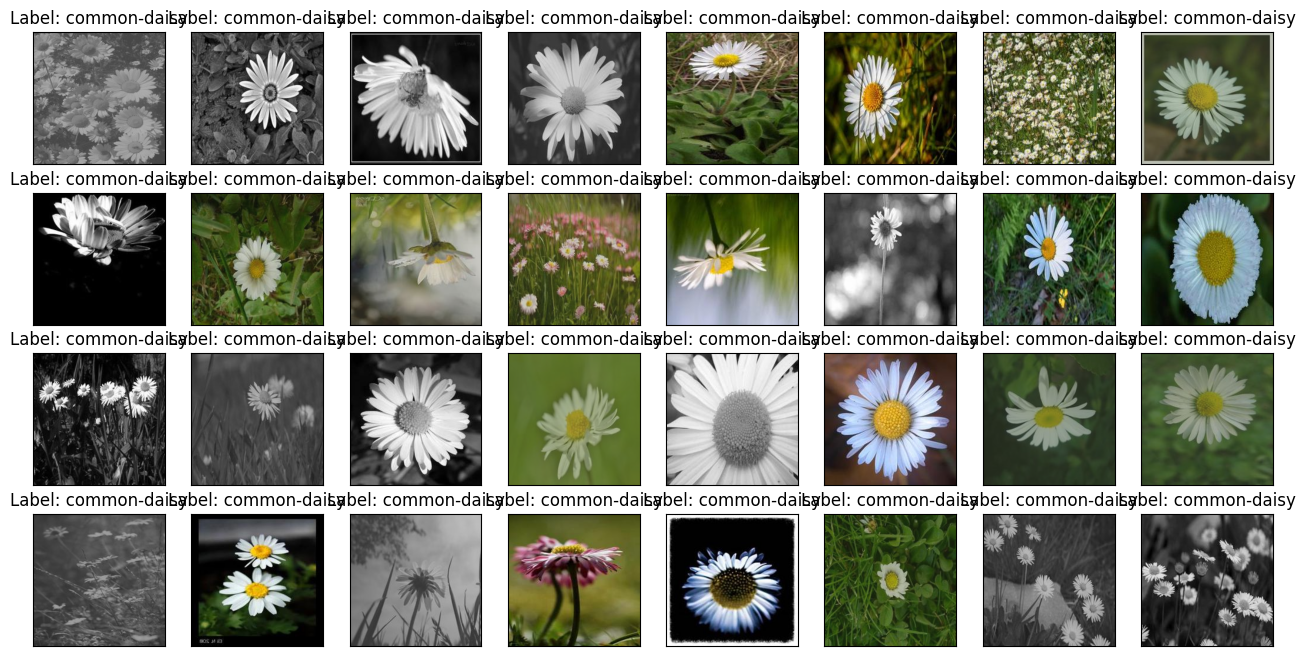

In [8]:
class_names = ['aloe-vera', 'astilbe', 'bellflower', 'black-eyed-susan', 'bougainvillea', 'calendula', 'california-poppy', 'carnation', 'chrysanthemum', 'common-daisy', 'coreopsis', 'daffodil',
               'dahlia', 'dandelion', 'golden-barrel-cactus', 'hibiscus', 'iris', 'jasmine', 'lavender', 'lily', 'lotus', 'magnolia', 'marigold', 'rose', 'snake-plant', 'sunflower', 'tulip', 'water-lily']

peek_labels(training_dataset, class_names=class_names)

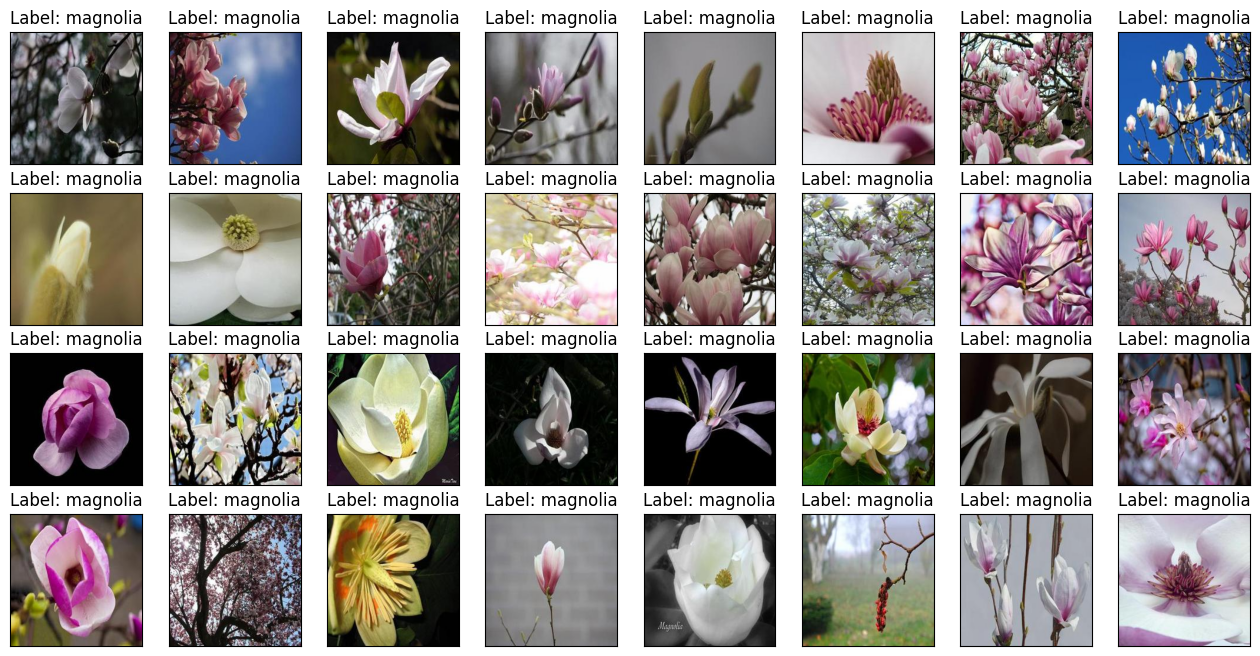

In [9]:
peek_labels(validation_dataset, class_names=class_names)

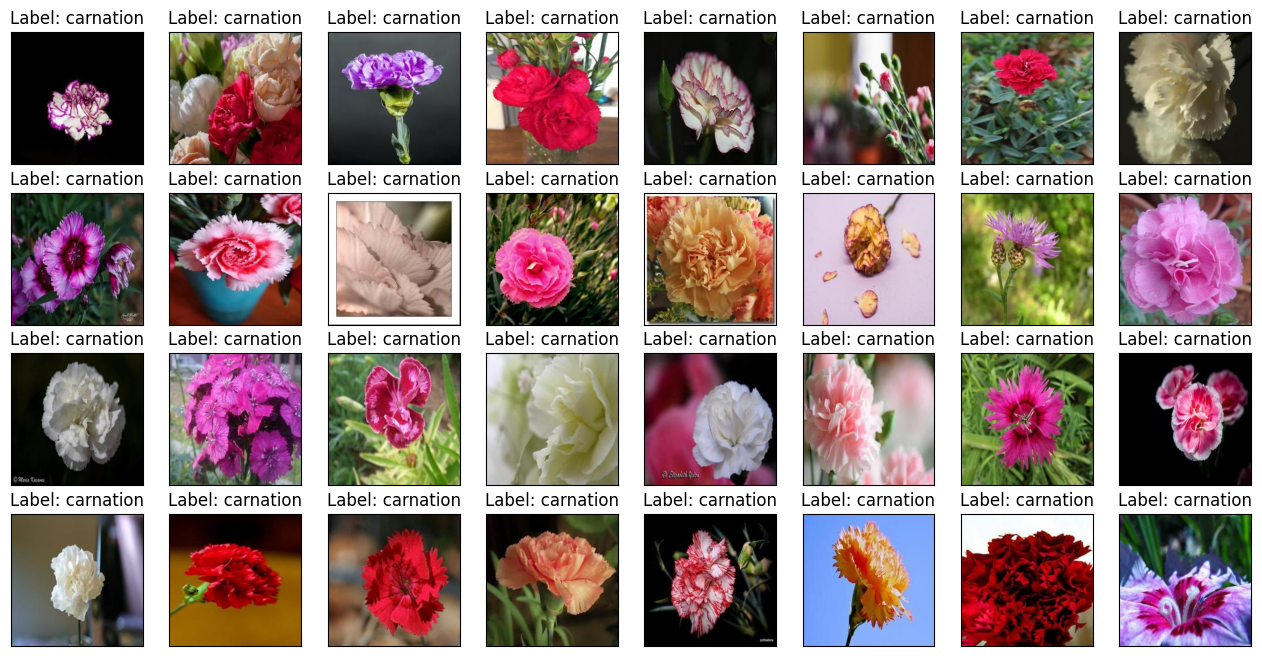

In [10]:
peek_labels(testing_dataset, class_names=class_names)

## 3. Build Model


In [11]:
from tensorflow.keras import Model, layers, optimizers, models, callbacks, applications
import tensorflow_hub as hub


def build_model():
    input_layer = layers.Input(shape=(DIMENSIONS, DIMENSIONS, 3))
    feature_extractor = applications.mobilenet_v2.MobileNetV2(
        input_shape=(DIMENSIONS, DIMENSIONS, 3),
        include_top=False,
        weights='imagenet'
    )
    feature_extractor.trainable = True
    # feature_extractor = hub.KerasLayer('https://tfhub.dev/google/imagenet/mobilenet_v3_small_075_224/feature_vector/5', trainable=True)(input_layer)
    # flatten_layer = layers.Flatten()(feature_extractor)
    feature_extractor = feature_extractor(input_layer, training=True)
    flatten_layer = layers.GlobalAveragePooling2D()(feature_extractor)
    dropout_layer = layers.Dropout(0.2)(flatten_layer)
    hidden_layer = layers.Dense(128, activation='relu')(dropout_layer)
    dropout_layer = layers.Dropout(0.2)(hidden_layer)
    hidden_layer = layers.Dense(64, activation='relu')(dropout_layer)
    dropout_layer = layers.Dropout(0.2)(hidden_layer)
    hidden_layer = layers.Dense(32, activation='relu')(dropout_layer)
    dropout_layer = layers.Dropout(0.2)(hidden_layer)
    predictions = layers.Dense(
        data_classes_count, activation='softmax')(dropout_layer)
    model = Model(inputs=input_layer, outputs=predictions)

    LEARNING_RATE = 0.001
    optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)

    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model


DEVELOPMENT_MODEL_PATH = f"{ROOT_PATH}/model/develop"
VERSION_TAG = "0.2.0-46"
BUILD_MODEL = True

if BUILD_MODEL:
    model = build_model()
else:
    model = models.load_model(f'{DEVELOPMENT_MODEL_PATH}/v{VERSION_TAG}.keras')

model.summary()

KeyboardInterrupt: 

## 4. Train Model


In [ ]:
%%time

VERSION = "0.3.1"
CHECKPOINT_MODEL_PATH = f"{ROOT_PATH}/model/checkpoint/{VERSION}"

checkpoint_callback = callbacks.ModelCheckpoint(filepath=CHECKPOINT_MODEL_PATH, save_weights_only=True, verbose=1)
# callbacks=[checkpoint_callback]
# Train the model
history = model.fit(training_dataset, epochs=EPOCHS, validation_data=validation_dataset)


### 4.2 Training Result


In [ ]:
# access metrics from training history
print("\ninitial | Training loss: {:.4f} | Validation Loss: {:.4f} || Training Accuracy: {:.2f} % | Validation Accuracy: {:.2f} %".format(
    history.history["loss"][0], history.history["val_loss"][0], history.history["accuracy"][0] * 100, history.history["val_accuracy"][0] * 100))
print(" latest | Training loss: {:.4f} | Validation Loss: {:.4f} || Training Accuracy: {:.2f} % | Validation Accuracy: {:.2f} %".format(
    history.history["loss"][-1], history.history["val_loss"][-1], history.history["accuracy"][-1] * 100, history.history["val_accuracy"][-1] * 100))

fig, axis = plt.subplots(1, 2, figsize=(10, 4))
# plot loss
axis[0].plot(history.history["loss"])
axis[0].plot(history.history["val_loss"], color='orange')
axis[0].set_title("loss per epoch")
# plot accuracy
axis[1].plot(history.history["accuracy"])
axis[1].plot(history.history["val_accuracy"], color='orange')
axis[1].set_title("accuracy per epoch")
plt.show()

## 5. Test Model


In [ ]:
# Evaluate the model
test_loss, test_acc = model.evaluate(testing_dataset)

print('Test loss:', test_loss, 'Test accuracy:', test_acc)

## 6. Visualize Result


In [ ]:
from sklearn import metrics

true_labels = []
for _, labels in testing_dataset:
    true_labels.extend(labels.numpy())

predictions = model.predict(testing_dataset)
predicted_labels = tf.math.argmax(predictions, axis=1).numpy()

confusion_matrix = metrics.confusion_matrix(true_labels, predicted_labels)
cm_display = metrics.ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix, display_labels=data_classes)

cm_display.plot()

# Rotate x-axis labels by 15 degrees
plt.xticks(rotation=90)
plt.show()

## 7. Save Model


In [ ]:
VERSION_TAG = input("Enter Version Tag (e.g 0.0.0):") + \
    f"-{int(test_acc * 100)}" if BUILD_MODEL else VERSION_TAG  # "0.0.0"

models.save_model(
    model, f'{DEVELOPMENT_MODEL_PATH}/v{VERSION_TAG}.h5', save_format="h5")